# Exploring data with BigQuery
## Setup Working Directory

In [1]:
import sys
import os
import pathlib

workingdir=os.getcwd()
#print(workingdir)
d=[d for d in os.listdir(workingdir)]
n=0
while not set(['notebook']).issubset(set(d)):
    workingdir=str(pathlib.Path(workingdir).parents[0])
    #print(workingdir)
    
    
    
    
    d=[d for d in os.listdir(str(workingdir))]
    n+=1
    if n>5:
        break
sys.path.insert(0, workingdir)
os.chdir(workingdir)

## Import libraries

In [2]:
# Import the client library
import google.cloud.dlp
import os
import subprocess
import json 
import requests
import getpass
import urllib.parse

## Defined GCP env variables

In [3]:
os.environ['PROJECT_ID'] = subprocess.run('gcloud config list project --format "value(core.project)"', 
                                          shell=True, check=True, stdout=subprocess.PIPE) \
                                            .stdout.decode().replace('\n', '').replace('\r', '')
print(os.environ['PROJECT_ID'])

axa-ch-machine-learning-dev


In [4]:
# bucket storage name
os.environ['BUCKET_NAME']='axa-ch-machine-learning-poc-dev'

In [5]:
try:
    tmp=os.environ['PROJECT_ID']
except:
    print('Env variable PROJECT not defined!') 

try:
    tmp=os.environ['BUCKET_NAME']
except:
    print('Env variable BUCKET_NAME not defined!') 
    
try:    
    tmp=os.environ['GOOGLE_APPLICATION_CREDENTIALS']
except:
    print('Env variable GOOGLE_APPLICATION_CREDENTIALS not defined!') 

try:
    tmp=os.environ['REQUESTS_CA_BUNDLE']
except:
    print('Env variable REQUESTS_CA_BUNDLE not defined!') 

try:
    tmp=os.environ['AXA_CH_CA_BUNDLE']
except:
    print('Env variable AXA_CA_CA_BUNDLE not defined!') 

## Testing everything

In [6]:
# use env variables
use_proxy='Y'
proxies = {
    'https': os.environ['HTTPS_PROXY'],    
    'http': os.environ['HTTP_PROXY']
}  

In [7]:
list_url=['https://www.google.com',
          'http://www.google.com',
          'https://www.example.com',
          'http://www.example.com',
          'https://github.com/j0hannes/cutter-ng']

for url in list_url:
    print('')
    print('trying to access:'+url)
    try:
        if use_proxy=='N':
            r = requests.get(url)
        else:
            # SSL deactivated
            #r = requests.get(url,proxies=proxies,verify=False)
            r = requests.get(url,proxies=proxies,verify=True)
            
        if r.status_code == requests.codes.ok:
            print('=>OK',r.headers['content-type'])
        else:
            # 407 Proxy Authentication Required
            print ('=> ??', r.status_code)
    except Exception as inst:
        print('=>FAILED')
        print(type(inst))    # the exception instance
        print(inst.args)     # arguments stored in .args
        print(inst)


trying to access:https://www.google.com
=>OK text/html; charset=ISO-8859-1

trying to access:http://www.google.com
=>OK text/html; charset=ISO-8859-1

trying to access:https://www.example.com
=>OK text/html; charset=UTF-8

trying to access:http://www.example.com
=>OK text/html; charset=UTF-8

trying to access:https://github.com/j0hannes/cutter-ng
=>OK text/html; charset=utf-8


## Test of the proxy with Gloud Storage

In [8]:
from google.cloud import storage
storage_client = storage.Client()
buckets = storage_client.list_buckets()

for bucket in buckets:
    print(bucket.name)
    

blobs = storage_client.list_blobs(os.environ['BUCKET_NAME'])
for blob in blobs:
    print(blob.name)
    break

artifacts.axa-ch-machine-learning-dev.appspot.com
axa-ch-machine-learning-dev-lcm
axa-ch-machine-learning-dev-vcm
axa-ch-machine-learning-dev.appspot.com
axa-ch-machine-learning-dev_cloudbuild
axa-ch-machine-learning-poc-dev
axa-ch-project-build-cache
cloud-build-slack
dataprep-staging-216e5014-18fe-4dea-a142-09b6ebf6d667
europe-west1-test-b090db08-bucket
staging.axa-ch-machine-learning-dev.appspot.com
certificates/


## Test of the proxy with BigQuery

In [9]:
from google.cloud import bigquery
client = bigquery.Client()

query = """SELECT
  EXTRACT(YEAR FROM creation_date) AS Year,
  COUNT(*) AS Number_of_Questions,
  ROUND(100 * SUM(IF(answer_count > 0, 1, 0)) / COUNT(*), 1) AS Percent_Questions_with_Answers
FROM
  `bigquery-public-data.stackoverflow.posts_questions`
GROUP BY
  Year
HAVING
  Year > 2008 AND Year < 2016
ORDER BY
  Year
"""
#df = client.query(query).to_dataframe()
#df.head()
query_job = client.query(query)
rows = query_job.result()  # Waits for query to finish

for row in rows:
    print(row)

Row((2009, 342995, 99.6), {'Year': 0, 'Number_of_Questions': 1, 'Percent_Questions_with_Answers': 2})
Row((2010, 693152, 99.1), {'Year': 0, 'Number_of_Questions': 1, 'Percent_Questions_with_Answers': 2})
Row((2011, 1198188, 97.2), {'Year': 0, 'Number_of_Questions': 1, 'Percent_Questions_with_Answers': 2})
Row((2012, 1642244, 94.6), {'Year': 0, 'Number_of_Questions': 1, 'Percent_Questions_with_Answers': 2})
Row((2013, 2055803, 91.7), {'Year': 0, 'Number_of_Questions': 1, 'Percent_Questions_with_Answers': 2})
Row((2014, 2159044, 88.6), {'Year': 0, 'Number_of_Questions': 1, 'Percent_Questions_with_Answers': 2})
Row((2015, 2213042, 86.4), {'Year': 0, 'Number_of_Questions': 1, 'Percent_Questions_with_Answers': 2})


## Getting medatadata about the tables

In [10]:
# dataset_id = 'your-project.your_dataset'
dataset_id =  'bigquery-public-data.stackoverflow'
tables = client.list_tables(dataset_id)

print("Tables contained in '{}':".format(dataset_id))
for table in tables:
    print("{}.{}.{}".format(table.project, table.dataset_id, table.table_id))

Tables contained in 'bigquery-public-data.stackoverflow':
bigquery-public-data.stackoverflow.badges
bigquery-public-data.stackoverflow.comments
bigquery-public-data.stackoverflow.post_history
bigquery-public-data.stackoverflow.post_links
bigquery-public-data.stackoverflow.posts_answers
bigquery-public-data.stackoverflow.posts_moderator_nomination
bigquery-public-data.stackoverflow.posts_orphaned_tag_wiki
bigquery-public-data.stackoverflow.posts_privilege_wiki
bigquery-public-data.stackoverflow.posts_questions
bigquery-public-data.stackoverflow.posts_tag_wiki
bigquery-public-data.stackoverflow.posts_tag_wiki_excerpt
bigquery-public-data.stackoverflow.posts_wiki_placeholder
bigquery-public-data.stackoverflow.stackoverflow_posts
bigquery-public-data.stackoverflow.tags
bigquery-public-data.stackoverflow.users
bigquery-public-data.stackoverflow.votes


In [11]:
client = bigquery.Client()

query = """SELECT
 * EXCEPT(is_typed)
FROM
 `bigquery-public-data.stackoverflow`.INFORMATION_SCHEMA.TABLES
"""
df = client.query(query).to_dataframe()
df.head()

,table_catalog,table_schema,table_name,table_type,is_insertable_into,creation_time
0,bigquery-public-data,stackoverflow,posts_answers,BASE TABLE,YES,2016-10-31 18:31:25.583000+00:00
1,bigquery-public-data,stackoverflow,users,BASE TABLE,YES,2016-10-26 13:29:37.954000+00:00
2,bigquery-public-data,stackoverflow,posts_orphaned_tag_wiki,BASE TABLE,YES,2016-10-31 16:41:37.010000+00:00
3,bigquery-public-data,stackoverflow,posts_tag_wiki,BASE TABLE,YES,2016-10-31 16:22:35.603000+00:00
4,bigquery-public-data,stackoverflow,stackoverflow_posts,BASE TABLE,YES,2016-09-21 13:42:24.544000+00:00


In [12]:
client = bigquery.Client()

query = """SELECT
 * EXCEPT(is_generated, generation_expression, is_stored, is_updatable)
FROM
 `bigquery-public-data.stackoverflow`.INFORMATION_SCHEMA.COLUMNS
WHERE
 table_name="posts_answers"
"""
df = client.query(query).to_dataframe()
print(len(df))
df

20


,table_catalog,table_schema,table_name,column_name,ordinal_position,is_nullable,data_type,is_hidden,is_system_defined,is_partitioning_column,clustering_ordinal_position
0,bigquery-public-data,stackoverflow,posts_answers,id,1,YES,INT64,NO,NO,NO,None
1,bigquery-public-data,stackoverflow,posts_answers,title,2,YES,STRING,NO,NO,NO,None
2,bigquery-public-data,stackoverflow,posts_answers,body,3,YES,STRING,NO,NO,NO,None
3,bigquery-public-data,stackoverflow,posts_answers,accepted_answer_id,4,YES,STRING,NO,NO,NO,None
4,bigquery-public-data,stackoverflow,posts_answers,answer_count,5,YES,STRING,NO,NO,NO,None
5,bigquery-public-data,stackoverflow,posts_answers,comment_count,6,YES,INT64,NO,NO,NO,None
6,bigquery-public-data,stackoverflow,posts_answers,community_owned_date,7,YES,TIMESTAMP,NO,NO,NO,None
7,bigquery-public-data,stackoverflow,posts_answers,creation_date,8,YES,TIMESTAMP,NO,NO,NO,None
8,bigquery-public-data,stackoverflow,posts_answers,favorite_count,9,YES,STRING,NO,NO,NO,None
9,bigquery-public-data,stackoverflow,posts_answers,last_activity_date,10,YES,TIMESTAMP,NO,NO,NO,None


In [13]:
client = bigquery.Client()

query = """SELECT
 * EXCEPT(is_generated, generation_expression, is_stored, is_updatable)
FROM
 `bigquery-public-data.stackoverflow`.INFORMATION_SCHEMA.COLUMNS
WHERE
 table_name="stackoverflow_posts"
"""
df = client.query(query).to_dataframe()
print(len(df))
df

20


,table_catalog,table_schema,table_name,column_name,ordinal_position,is_nullable,data_type,is_hidden,is_system_defined,is_partitioning_column,clustering_ordinal_position
0,bigquery-public-data,stackoverflow,stackoverflow_posts,id,1,NO,INT64,NO,NO,NO,None
1,bigquery-public-data,stackoverflow,stackoverflow_posts,title,2,YES,STRING,NO,NO,NO,None
2,bigquery-public-data,stackoverflow,stackoverflow_posts,body,3,YES,STRING,NO,NO,NO,None
3,bigquery-public-data,stackoverflow,stackoverflow_posts,accepted_answer_id,4,YES,INT64,NO,NO,NO,None
4,bigquery-public-data,stackoverflow,stackoverflow_posts,answer_count,5,YES,INT64,NO,NO,NO,None
5,bigquery-public-data,stackoverflow,stackoverflow_posts,comment_count,6,YES,INT64,NO,NO,NO,None
6,bigquery-public-data,stackoverflow,stackoverflow_posts,community_owned_date,7,YES,TIMESTAMP,NO,NO,NO,None
7,bigquery-public-data,stackoverflow,stackoverflow_posts,creation_date,8,YES,TIMESTAMP,NO,NO,NO,None
8,bigquery-public-data,stackoverflow,stackoverflow_posts,favorite_count,9,YES,INT64,NO,NO,NO,None
9,bigquery-public-data,stackoverflow,stackoverflow_posts,last_activity_date,10,YES,TIMESTAMP,NO,NO,NO,None


In [14]:
client = bigquery.Client()

query = ("""
SELECT
 * 
FROM
 `bigquery-public-data.stackoverflow`.INFORMATION_SCHEMA.COLUMN_FIELD_PATHS
WHERE
 table_name="stackoverflow_posts"
""")
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query


df = query_job.to_dataframe()
print(len(df))
df

20


,table_catalog,table_schema,table_name,column_name,field_path,data_type,description
0,bigquery-public-data,stackoverflow,stackoverflow_posts,id,id,INT64,None
1,bigquery-public-data,stackoverflow,stackoverflow_posts,title,title,STRING,None
2,bigquery-public-data,stackoverflow,stackoverflow_posts,body,body,STRING,None
3,bigquery-public-data,stackoverflow,stackoverflow_posts,accepted_answer_id,accepted_answer_id,INT64,None
4,bigquery-public-data,stackoverflow,stackoverflow_posts,answer_count,answer_count,INT64,None
5,bigquery-public-data,stackoverflow,stackoverflow_posts,comment_count,comment_count,INT64,None
6,bigquery-public-data,stackoverflow,stackoverflow_posts,community_owned_date,community_owned_date,TIMESTAMP,None
7,bigquery-public-data,stackoverflow,stackoverflow_posts,creation_date,creation_date,TIMESTAMP,None
8,bigquery-public-data,stackoverflow,stackoverflow_posts,favorite_count,favorite_count,INT64,None
9,bigquery-public-data,stackoverflow,stackoverflow_posts,last_activity_date,last_activity_date,TIMESTAMP,None


## Doing a dry test with a query

In [15]:
#client = bigquery.Client()
    #
    #job_config = bigquery.QueryJobConfig()
    #job_config.dry_run = True
    #job_config.use_query_cache = False
    #query_job = client.query(
        #("""
        #SELECT *
        #FROM `bigquery-public-data.stackoverflow.stackoverflow_posts`
        #"""),
        ## Location must match that of the dataset(s) referenced in the query.
        #location="US",
        #job_config=job_config,
    #)  # API request
    #
    ## A dry run query completes immediately.
    #assert query_job.state == "DONE"
    #assert query_job.dry_run
    #
    #print("This query will process {} bytes ({} Gb).".format(query_job.total_bytes_processed, query_job.total_bytes_processed/1e+9))

## Creating a table

In [16]:
dataset_id ='test'

job_config = bigquery.QueryJobConfig()

# Set the destination table
table_ref = client.dataset(dataset_id).table('schema_stackoverflow')
job_config.destination = table_ref
sql = """
SELECT
 * 
FROM
 `bigquery-public-data.stackoverflow`.INFORMATION_SCHEMA.COLUMN_FIELD_PATHS
WHERE
 table_name="stackoverflow_posts"
"""

# Start the query, passing in the extra configuration.
query_job = client.query(
    sql,
    # Location must match that of the dataset(s) referenced in the query
    # and of the destination table.
    location='US',
    job_config=job_config)  # API request - starts the query

query_job.result()  # Waits for the query to finish
print('Query results loaded to table {}'.format(table_ref.path))

Conflict: 409 Already Exists: Table axa-ch-machine-learning-dev:test.schema_stackoverflow

## Viewing a table

In [ ]:
client = bigquery.Client()

query = """SELECT
*
FROM
 `bigquery-public-data.stackoverflow.stackoverflow_posts`
WHERE tags="python"
"""
df = client.query(query).to_dataframe()
print(len(df))
df.head(20)

# Exploratory Data Analysis

## Random Subset

In [17]:
sql = """CREATE TABLE
  `axa-ch-machine-learning-dev.nlp_text_classification.stackoverflow_posts_questions` AS (
  SELECT
    *
  FROM
    `bigquery-public-data.stackoverflow.posts_questions`
  WHERE
    RAND() < 0.01)"""

## Exploring XXX

### Number of Views Per Record

In [22]:
query = """SELECT
  *
FROM
  `axa-ch-machine-learning-dev.nlp_text_classification.stackoverflow_posts_questions_small`"""
df_small = client.query(query).to_dataframe()

In [25]:
df_small.head()

,id,title,body,accepted_answer_id,answer_count,comment_count,community_owned_date,creation_date,favorite_count,last_activity_date,last_edit_date,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,parent_id,post_type_id,score,tags,view_count
0,22804521,how to push my github repo into openshift and ...,<p>i'm newbie to openshift and git.I've my rep...,NaN,2,1,None,2014-04-02 07:34:06.840000+00:00,NaN,2014-09-02 23:53:30.343000+00:00,NaT,None,NaN,None,3488259.0,None,1,0,gitgithubsftpopenshift,256
1,47530134,`Trace: TypeError: React.__spread is not a fun...,<p>I was seeing a warning about this when I wa...,NaN,1,15,None,2017-11-28 11:11:28.023000+00:00,NaN,2017-11-28 12:49:25.707000+00:00,2017-11-28 12:15:47.737000+00:00,None,4015856.0,None,4015856.0,None,1,0,reactjsreact-reduxbabel,256
2,35257755,Append mouseover event to img in a div with jQ...,<p>I am trying to append a mouseover event to ...,35257815.0,1,0,None,2016-02-07 19:04:45.170000+00:00,NaN,2016-02-07 20:30:15.287000+00:00,NaT,None,NaN,None,5448626.0,None,1,0,jquery,256
3,31909648,Connect on website with HttpWebRequest,<p>I tried to use HttpWebRequest to connect on...,NaN,0,3,None,2015-08-09 23:00:17.090000+00:00,NaN,2015-08-10 16:59:35.420000+00:00,2015-08-10 16:59:35.420000+00:00,None,5182869.0,None,5182869.0,None,1,0,c#httpwebrequestwebclientwebclient-download,256
4,50601033,HTTP outbound gateway - uri variable - encoding,"<p>I have a http outbound gateway, which requi...",NaN,0,6,None,2018-05-30 09:25:08.833000+00:00,NaN,2018-05-30 14:23:15.030000+00:00,2018-05-30 14:23:15.030000+00:00,None,2017299.0,None,2017299.0,None,1,0,springspring-integrationgatewayoutbound,256


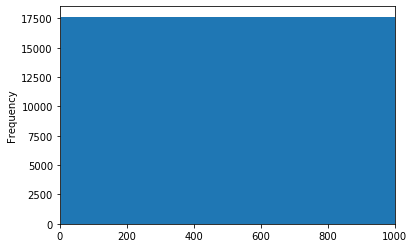

In [31]:
df_small['view_count'].plot(kind='hist', xlim=[0, 1000])

## Answer-View Ratio

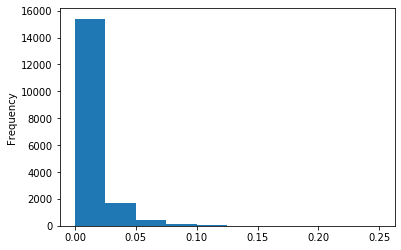

In [34]:
df_small['view_answer_ratio'] = df_small['answer_count']/df_small['view_count']
df_small['view_answer_ratio'].plot(kind='hist')